# Experiments and results

Here the results of the experiments are plotted.

### Plotting functions

In [1]:
import configuration
import os
import tensorflow as tf
import glob
import pandas as pd
from matplotlib import pyplot as plt
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """
    Curve smoothing https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
    """
    import numpy as np
    from math import factorial
    y = np.array(y)
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def get_single_series(path_to_events_file, scalar_key):
    model_name = path_to_events_file.split(os.path.sep)[-2]
    print("\tGetting %s from %s" % (scalar_key, model_name))
    steps = []
    values = []
    for e in tf.train.summary_iterator(path_to_events_file):   
        for v in e.summary.value:
            if scalar_key in v.tag:
                values.append(v.simple_value)
                steps.append(e.step)
    series = pd.Series(index = steps, data = values)
    return series

def get_all_series_averaged(folder_key, scalar_key, experiment_folder,
                                                                steps_mode):
    print("Searching for folder_key='%s'" % folder_key)
    series_list = []
    run_paths = [os.path.join(experiment_folder, f) for f in \
                             os.listdir(experiment_folder) if folder_key in f]
    training_times = []
    for run_path in run_paths:
        try:
            path_to_events_file = glob.glob(os.path.join(run_path,'events.out*'))[0]
        except IndexError:
            print("\tHasn't even started")
            series = pd.Series()
        else:
            series = get_single_series(path_to_events_file, scalar_key)
        try:
            with open(os.path.join(run_path,'total_training_seconds.txt')) as fp:
                content = fp.read()
            training_time = float(content) / 3600
            training_times.append(training_time)
        except:
            print("\tNot finished")
        series_list.append(series)
        print(len(series))
    
    df = pd.DataFrame(series_list)
    means = df.mean(axis = 0)
    stds = df.std(axis = 0)
    steps = df.columns.to_series()
    
    if steps_mode == 'millions':
        steps /= 1e6
    elif steps_mode == 'thousands':
        steps /= 1e3
    try:
        avg_training_time = sum(training_times) / len(training_times)
    except:
        avg_training_time = -1
    data = {'means' : means,
            'stds'  : stds,
            'steps' : steps,
            'time'  : avg_training_time}
                
    return data


def get_datas(folder_keys, scalar_key, experiment_folder, steps_mode):
    datas = []
    for folder_key in folder_keys:
        data = get_all_series_averaged(folder_key = folder_key,
                                       scalar_key = scalar_key,
                                       experiment_folder = experiment_folder,
                                       steps_mode = steps_mode)
        datas.append(data)    
    return datas


gl = configuration.GlobalSettings()

### Toy problem

In [ ]:
experiment_folder = os.path.join(gl.logs_dir, 'exp1')
steps_mode = 'thousands'
data_hdqn = get_all_series_averaged(folder_key = 'athdqn',
                                   scalar_key = 'mc_avg_ep_reward',
                                   experiment_folder = experiment_folder,
                                   steps_mode = steps_mode)
data_dqn = get_all_series_averaged(folder_key = 'atdqn',
                                   scalar_key = 'avg_ep_reward',
                                   experiment_folder = experiment_folder,
                                   steps_mode = steps_mode)
datas = [data_dqn, data_hdqn]
labels = ['DQN', 'hDQN']
colors = ['red', 'blue']
alpha = .5
linewidth = 0
fontsize = 15
plt.figure()
for data, label, color in zip(datas, labels, colors):
    err, means, steps = data['stds'], data['means'], data['steps']
    plt.plot(steps, means, label = label, color = color)
    plt.fill_between(steps,
                     means - err,
                     means + err,
                     alpha = alpha, color = color,linewidth = linewidth)
plt.ylabel('Average episode $R$', fontsize = fontsize)
plt.xlabel('%s of steps' % steps_mode.capitalize(), fontsize = fontsize)
plt.legend(fontsize = fontsize,
           loc = 'lower right')
plt.show()

### DQN Extensions

In [13]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/21d18h32m42s_extensions_exp'
steps_mode = 'millions'
scalar_key = 'avg_ep_reward'
labels = ['Vanilla', 'Double Q', 'Dueling', 'Prioritized Replay', 'Rainbow']
folder_keys = [ 'dq0_d0_p0',  'dq1_d0_p0', 'dq0_d1_p0', 'dq0_d0_p1', 'dq1_d1_p1']
datas = get_datas(folder_keys, scalar_key, experiment_folder, steps_mode)

Searching for folder_key='dq0_d0_p0'
	Getting avg_ep_reward from d21d18h32m42s_gg_enSF-v0_e1_atdqn_a512-512_dq0_d0_p0_ar5_rs4
	Not finished
	Getting avg_ep_reward from d21d18h32m42s_gg_enSF-v0_e1_atdqn_a512-512_dq0_d0_p0_ar5_rs0
	Not finished
	Getting avg_ep_reward from d21d18h32m42s_gg_enSF-v0_e1_atdqn_a512-512_dq0_d0_p0_ar5_rs1
	Not finished
	Getting avg_ep_reward from d21d18h32m42s_gg_enSF-v0_e1_atdqn_a512-512_dq0_d0_p0_ar5_rs2
	Not finished
	Getting avg_ep_reward from d21d18h32m42s_gg_enSF-v0_e1_atdqn_a512-512_dq0_d0_p0_ar5_rs3
Searching for folder_key='dq1_d0_p0'
	Getting avg_ep_reward from d21d18h32m42s_gg_enSF-v0_e1_atdqn_a512-512_dq1_d0_p0_ar5_rs0
	Not finished
	Getting avg_ep_reward from d21d18h32m42s_gg_enSF-v0_e1_atdqn_a512-512_dq1_d0_p0_ar5_rs1
	Not finished
	Getting avg_ep_reward from d21d18h32m42s_gg_enSF-v0_e1_atdqn_a512-512_dq1_d0_p0_ar5_rs2
	Not finished
	Getting avg_ep_reward from d21d18h32m42s_gg_enSF-v0_e1_atdqn_a512-512_dq1_d0_p0_ar5_rs4
	Not finished
	Getting avg_

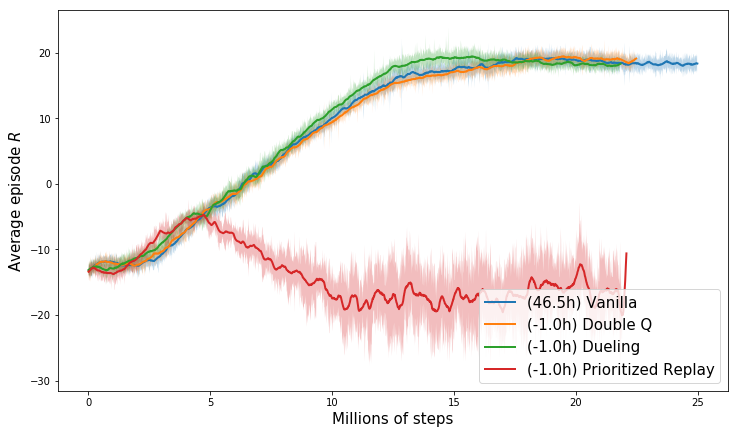

In [14]:
alpha = .3
linewidth = 0
fontsize = 15
plt.figure(figsize = (12, 7))
for data, label in zip(datas, labels):
    err, means, steps, t = data['stds'], data['means'], data['steps'], data['time']
    if len(steps) == 0:
            continue
    means = savitzky_golay(means, 51, 3)
    final_label = "(%.1fh) %s" % (t, label)
    plt.plot(steps, means, label = final_label, linewidth = 2)
    plt.fill_between(steps,
                     means - err,
                     means + err,
                     alpha = alpha,linewidth = linewidth)
plt.ylabel('Average episode $R$', fontsize = fontsize)
plt.xlabel('%s of steps' % steps_mode.capitalize(), fontsize = fontsize)
plt.legend(fontsize = fontsize,
           loc = 'lower right')
plt.show()

### Action repeat

In [15]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/21d18h32m32s_action_repeat_exp'
steps_mode = 'millions'
scalar_key = 'avg_ep_reward'
actions_repeats = list(range(1, 8))
labels = ["ar=%d" % ar for ar in actions_repeats]
folder_keys = ["ar%d_" % ar for ar in actions_repeats]
datas = get_datas(folder_keys, scalar_key, experiment_folder, steps_mode)

Searching for folder_key='ar1_'
	Getting avg_ep_reward from d21d18h32m32s_gg_enSF-v0_e1_atdqn_a512-512_dq0_d0_p0_ar1_rs3
	Getting avg_ep_reward from d21d18h32m32s_gg_enSF-v0_e1_atdqn_a512-512_dq0_d0_p0_ar1_rs2
	Getting avg_ep_reward from d21d18h32m32s_gg_enSF-v0_e1_atdqn_a512-512_dq0_d0_p0_ar1_rs0
	Getting avg_ep_reward from d21d18h32m32s_gg_enSF-v0_e1_atdqn_a512-512_dq0_d0_p0_ar1_rs1
Searching for folder_key='ar2_'
	Getting avg_ep_reward from d21d18h32m32s_gg_enSF-v0_e1_atdqn_a512-512_dq0_d0_p0_ar2_rs1
	Getting avg_ep_reward from d21d18h32m32s_gg_enSF-v0_e1_atdqn_a512-512_dq0_d0_p0_ar2_rs2
	Getting avg_ep_reward from d21d18h32m32s_gg_enSF-v0_e1_atdqn_a512-512_dq0_d0_p0_ar2_rs3
	Getting avg_ep_reward from d21d18h32m32s_gg_enSF-v0_e1_atdqn_a512-512_dq0_d0_p0_ar2_rs0
Searching for folder_key='ar3_'
	Getting avg_ep_reward from d21d18h32m32s_gg_enSF-v0_e1_atdqn_a512-512_dq0_d0_p0_ar3_rs0
	Getting avg_ep_reward from d21d18h32m32s_gg_enSF-v0_e1_atdqn_a512-512_dq0_d0_p0_ar3_rs3
	Getting avg_e

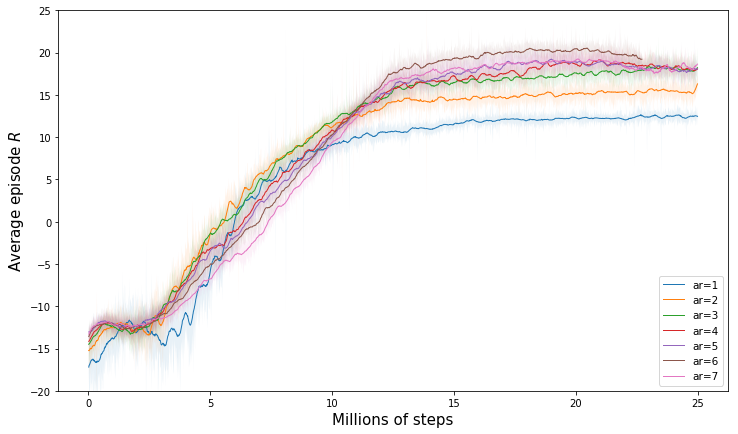

In [17]:
alpha = 1
linewidth = 0
fontsize = 15
plt.figure(figsize = (12,7))
for data, label in zip(datas, labels):
    err, means, steps = data['stds'], data['means'], data['steps']
    if len(steps) == 0:
        continue
    means = savitzky_golay(means, 51, 3)
    plt.plot(steps, means, label = label, linewidth = 1,
             alpha = alpha)
    plt.fill_between(steps,
                     means - err,
                     means + err,
                     alpha = .1 * alpha,linewidth = linewidth)
plt.ylabel('Average episode $R$', fontsize = fontsize)
plt.xlabel('%s of steps' % steps_mode.capitalize(), fontsize = fontsize)
plt.legend(fontsize = .7 * fontsize,
           loc = 'lower right')
plt.ylim([-20,25])
plt.show()

### Architectures

In [3]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/21d18h32m35s_architectures_exp'
steps_mode = 'millions'
scalar_key = 'avg_ep_reward'#'steps_to_destroy'#''
architectures = [[16],
                [64, 64],
                [64, 64, 64, 64],
                [512],
                [512, 512],
                [512, 512, 512, 512]]
labels = ['-'.join([str(n) for n in a]) for a in architectures]
folder_keys = ['a' + l + '_' for l in labels]
datas = get_datas(folder_keys, scalar_key, experiment_folder, steps_mode)

Searching for folder_key='a16_'
	Getting avg_ep_reward from d21d18h32m36s_gg_enSF-v0_e1_atdqn_a16_dq0_d0_p0_ar5_rs1
2498
	Getting avg_ep_reward from d21d18h32m36s_gg_enSF-v0_e1_atdqn_a16_dq0_d0_p0_ar5_rs0
2498
	Getting avg_ep_reward from d21d18h32m36s_gg_enSF-v0_e1_atdqn_a16_dq0_d0_p0_ar5_rs3
2498
	Getting avg_ep_reward from d21d18h32m36s_gg_enSF-v0_e1_atdqn_a16_dq0_d0_p0_ar5_rs2
2498
Searching for folder_key='a64-64_'
	Getting avg_ep_reward from d21d18h32m36s_gg_enSF-v0_e1_atdqn_a64-64_dq0_d0_p0_ar5_rs0
2498
	Getting avg_ep_reward from d21d18h32m36s_gg_enSF-v0_e1_atdqn_a64-64_dq0_d0_p0_ar5_rs3
2498
	Getting avg_ep_reward from d21d18h32m36s_gg_enSF-v0_e1_atdqn_a64-64_dq0_d0_p0_ar5_rs2
2498
	Getting avg_ep_reward from d21d18h32m36s_gg_enSF-v0_e1_atdqn_a64-64_dq0_d0_p0_ar5_rs1
2498
Searching for folder_key='a64-64-64-64_'
	Getting avg_ep_reward from d21d18h32m36s_gg_enSF-v0_e1_atdqn_a64-64-64-64_dq0_d0_p0_ar5_rs1
2498
	Getting avg_ep_reward from d21d18h32m36s_gg_enSF-v0_e1_atdqn_a64-64-6

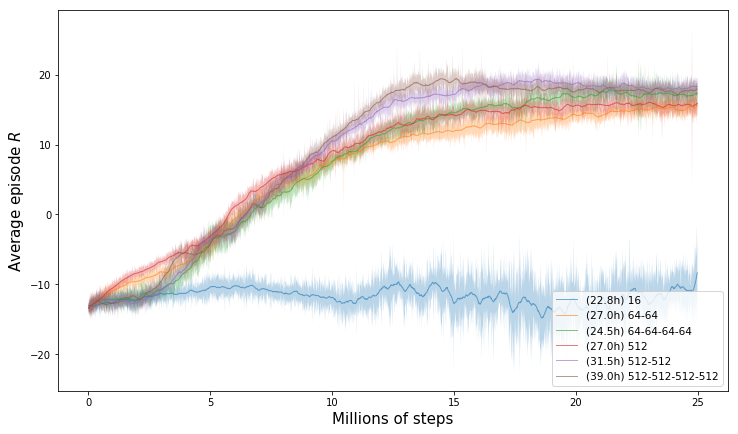

In [4]:
alpha = .6
linewidth = 0
fontsize = 15
plt.figure(figsize = (12,7))
for data, label in zip(datas, labels):
    err, means, steps, t = data['stds'], data['means'], data['steps'], data['time']
    if len(steps) == 0:
        continue
    means = savitzky_golay(means, 51, 3)
    final_label = "(%.1fh) %s" % (t, label)
    plt.plot(steps, means, label = final_label, linewidth = 1,
             alpha = alpha)
    plt.fill_between(steps,
                     means - err,
                     means + err,
                     alpha = .5 * alpha, linewidth = linewidth)
plt.ylabel('Average episode $R$', fontsize = fontsize)
plt.xlabel('%s of steps' % steps_mode.capitalize(), fontsize = fontsize)
plt.legend(fontsize = .7 * fontsize,
           loc = 'lower right')
plt.show()

### Goals

In [25]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/21d18h32m46s_goals_exp'
steps_mode = 'millions'
scalar_key = 'avg_ep_reward'
goal_groups = [1,2,3,4,5,6]
labels = ['gg%d' % gg for gg in goal_groups]
folder_keys = labels#['a' + l + '_' for l in labels]
datas = get_datas(folder_keys, scalar_key, experiment_folder, steps_mode)

Searching for folder_key='gg1'
	Getting avg_ep_reward from d21d18h32m47s_gg1_enSF-v0_e1_athdqn_a512-512_dq0_d0_p0_ar5_rs0
	Not finished
4868
	Getting avg_ep_reward from d21d18h32m47s_gg1_enSF-v0_e1_athdqn_a512-512_dq0_d0_p0_ar5_rs2
	Not finished
4888
	Getting avg_ep_reward from d21d18h32m47s_gg1_enSF-v0_e1_athdqn_a512-512_dq0_d0_p0_ar5_rs1
	Not finished
4884
	Getting avg_ep_reward from d21d18h32m47s_gg1_enSF-v0_e1_athdqn_a512-512_dq0_d0_p0_ar5_rs3
	Not finished
4904


InvalidIndexError: Reindexing only valid with uniquely valued Index objects